## Exercise Overview
In this exercise we will play with Spark [Datasets & Dataframes](https://spark.apache.org/docs/latest/sql-programming-guide.html#datasets-and-dataframes), some [Spark SQL](https://spark.apache.org/docs/latest/sql-programming-guide.html#sql), and build a couple of binary classifiaction models using [Spark ML](https://spark.apache.org/docs/latest/ml-guide.html) (with some [MLlib](https://spark.apache.org/mllib/) too). 
<br><br>
The set up and approach will not be too dissimilar to the standard type of approach you might do in [Sklearn](http://scikit-learn.org/stable/index.html). Spark has matured to the stage now where for 90% of what you need to do (when analysing tabular data) should be possible with Spark dataframes, SQL, and ML libraries. This is where this exercise is mainly trying to focus.  
<br>
Feel free to adapt this exercise to play with other datasets readily availabe in the Databricks enviornment (they are listed in a cell below). 

##### Getting Started
To get started you will need to create and attach a databricks spark cluster to this notebook. This notebook was developed on a cluster created with: 
- Databricks Runtime Version 4.0 (includes Apache Spark 2.3.0, Scala 2.11)
- Python Version 3

##### Links & References

Some useful links and references of sources used in creating this exercise:

**Note**: Right click and open as new tab!
<br>
1. [Latest Spark Docs](https://spark.apache.org/docs/latest/index.html)
1. [Databricks Homepage](https://databricks.com/)
1. [Databricks Community Edition FAQ](https://databricks.com/product/faq/community-edition)
1. [Databricks Self Paced Training](https://databricks.com/training-overview/training-self-paced)
1. [Databricks Notebook Guide](https://docs.databricks.com/user-guide/notebooks/index.html)
1. [Databricks Binary Classification Tutorial](https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html#binary-classification)

In [1]:
import pyspark
if 'sc' not in locals():
    from pyspark.context import SparkContext
    from pyspark.sql.context import SQLContext
    from pyspark.sql.session import SparkSession
    
    sc = SparkContext()
    sqlContext = SQLContext(sc)
    spark = SparkSession(sc)

spark

/home/tai/Desktop/Projects/SpringBoard/env/lib/python3.6/site-packages/pyspark/context.py:238: FutureWarning: Python 3.6 support is deprecated in Spark 3.2.
  FutureWarning


#### Get Data

Here we will pull in some sample data that is already pre-loaded onto all databricks clusters.

Feel free to adapt this notebook later to play around with a different dataset if you like (all available are listed in a cell below).

Lets take a look at the '**adult**' dataset on the filesystem. This is the typical US Census data you often see online in tutorials. [Here](https://archive.ics.uci.edu/ml/datasets/adult) is the same data in the UCI repository.

_As an aside: [here](https://github.com/GoogleCloudPlatform/cloudml-samples/tree/master/census) this same dataset is used as a quickstart example for Google CLoud ML & Tensorflow Estimator API (in case youd be interested in playing with tensorflow on the same dataset as here)._

**Note**: Above  %fs is just some file system cell magic that is specific to databricks. More info [here](https://docs.databricks.com/user-guide/notebooks/index.html#mix-languages).

#### Spark SQL

Below we will use Spark SQL to load in the data and then register it as a Dataframe aswell. So the end result will be a Spark SQL table called _adult_ and a Spark Dataframe called _df_adult_. 
<br><br>
This is an example of the flexibility in Spark in that you could do lots of you ETL and data wrangling using either Spark SQL or Dataframes and pyspark. Most of the time it's a case of using whatever you are most comfortable with.
<br><br>
When you get more advanced then you might looking the pro's and con's of each and when you might favour one or the other (or operating direclty on RDD's), [here](https://databricks.com/blog/2016/07/14/a-tale-of-three-apache-spark-apis-rdds-dataframes-and-datasets.html) is a good article on the issues. For now, no need to overthink it!

In [5]:
from pyspark.sql.types import DoubleType, StringType, StructType, StructField
 
schema = StructType([
  StructField("age", DoubleType(), False),
  StructField("workclass", StringType(), False),
  StructField("fnlwgt", DoubleType(), False),
  StructField("education", StringType(), False),
  StructField("education_num", DoubleType(), False),
  StructField("marital_status", StringType(), False),
  StructField("occupation", StringType(), False),
  StructField("relationship", StringType(), False),
  StructField("race", StringType(), False),
  StructField("sex", StringType(), False),
  StructField("capital_gain", DoubleType(), False),
  StructField("capital_loss", DoubleType(), False),
  StructField("hours_per_week", DoubleType(), False),
  StructField("native_country", StringType(), False),
  StructField("income", StringType(), False)
])
adult_df = spark.read.format("csv").schema(schema).load("adult.data")

In [6]:
type(adult_df)

pyspark.sql.dataframe.DataFrame

In [7]:
adult_df

DataFrame[age: double, workclass: string, fnlwgt: double, education: string, education_num: double, marital_status: string, occupation: string, relationship: string, race: string, sex: string, capital_gain: double, capital_loss: double, hours_per_week: double, native_country: string, income: string]

In [9]:
adult_df.write.option('header','true').saveAsTable("adult_table")

In [10]:
# look at the data
spark.sql("SELECT * FROM adult_table LIMIT 5").show() 
# this will look prettier in Databricks if you use display() instead
#display(spark.sql("SELECT * FROM adult_table LIMIT 5"))

+----+-----------------+--------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
| age|        workclass|  fnlwgt| education|education_num|     marital_status|        occupation|  relationship|  race|    sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+----+-----------------+--------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
|39.0|        State-gov| 77516.0| Bachelors|         13.0|      Never-married|      Adm-clerical| Not-in-family| White|   Male|      2174.0|         0.0|          40.0| United-States| <=50K|
|50.0| Self-emp-not-inc| 83311.0| Bachelors|         13.0| Married-civ-spouse|   Exec-managerial|       Husband| White|   Male|         0.0|         0.0|          13.0| United-States| <=50K|
|38.0|          Private|215646.0|   HS-grad| 

If you are more comfortable with SQL then as you can see below, its very easy to just get going with writing standard SQL type code to analyse your data, do data wrangling and create new dataframes.

In [11]:
# Lets get some summary marital status rates by occupation
result = spark.sql(
  """
  SELECT 
    occupation,
    SUM(1) as n,
    ROUND(AVG(if(LTRIM(marital_status) LIKE 'Married-%',1,0)),2) as married_rate,
    ROUND(AVG(if(lower(marital_status) LIKE '%widow%',1,0)),2) as widow_rate,
    ROUND(AVG(if(LTRIM(marital_status) = 'Divorced',1,0)),2) as divorce_rate,
    ROUND(AVG(if(LTRIM(marital_status) = 'Separated',1,0)),2) as separated_rate,
    ROUND(AVG(if(LTRIM(marital_status) = 'Never-married',1,0)),2) as bachelor_rate
  FROM 
    adult_table
  GROUP BY 1
  ORDER BY n DESC
  """)


In [14]:
display(result.head(5))

[Row(occupation=' Prof-specialty', n=4140, married_rate=0.53, widow_rate=0.02, divorce_rate=0.13, separated_rate=0.02, bachelor_rate=0.3),
 Row(occupation=' Craft-repair', n=4099, married_rate=0.64, widow_rate=0.01, divorce_rate=0.11, separated_rate=0.03, bachelor_rate=0.21),
 Row(occupation=' Exec-managerial', n=4066, married_rate=0.61, widow_rate=0.02, divorce_rate=0.15, separated_rate=0.02, bachelor_rate=0.2),
 Row(occupation=' Adm-clerical', n=3770, married_rate=0.28, widow_rate=0.04, divorce_rate=0.22, separated_rate=0.04, bachelor_rate=0.42),
 Row(occupation=' Sales', n=3650, married_rate=0.47, widow_rate=0.03, divorce_rate=0.12, separated_rate=0.03, bachelor_rate=0.36)]

You can easily register dataframes as a table for Spark SQL too. So this way you can easily move between Dataframes and Spark SQL for whatever reason.

In [15]:
# register the df we just made as a table for spark sql
sqlContext.registerDataFrameAsTable(result, "result")
spark.sql("SELECT * FROM result").show(5)

+----------------+----+------------+----------+------------+--------------+-------------+
|      occupation|   n|married_rate|widow_rate|divorce_rate|separated_rate|bachelor_rate|
+----------------+----+------------+----------+------------+--------------+-------------+
|  Prof-specialty|4140|        0.53|      0.02|        0.13|          0.02|          0.3|
|    Craft-repair|4099|        0.64|      0.01|        0.11|          0.03|         0.21|
| Exec-managerial|4066|        0.61|      0.02|        0.15|          0.02|          0.2|
|    Adm-clerical|3770|        0.28|      0.04|        0.22|          0.04|         0.42|
|           Sales|3650|        0.47|      0.03|        0.12|          0.03|         0.36|
+----------------+----+------------+----------+------------+--------------+-------------+
only showing top 5 rows



#### <span style="color:darkblue">Question 1</span>

1. Write some spark sql to get the top 'bachelor_rate' by 'education' group?

In [20]:
### Question 1.1 Answer ###

result_2 = spark.sql(
    """
    SELECT 
        SUM(1) as n,
        education,
        ROUND(AVG(if(LTRIM(marital_status) = 'Never-married',1,0)),2) as bachelor_rate

    FROM 
        adult_table
    GROUP BY 2
    ORDER BY 3 DESC
    LIMIT 1
    """
)
result_2.show()

+---+---------+-------------+
|  n|education|bachelor_rate|
+---+---------+-------------+
|433|     12th|         0.54|
+---+---------+-------------+



#### Spark DataFrames

Below we will create our DataFrame from the SQL table and do some similar analysis as we did with Spark SQL but using the DataFrames API.

In [21]:
# register a df from the sql df
df_adult = spark.table("adult_table")
cols = df_adult.columns # this will be used much later in the notebook, ignore for now

In [22]:
# look at df schema
df_adult.printSchema()

root
 |-- age: double (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)



In [24]:
# look at the df
#display(df_adult)
df_adult.show(5)

+----+-----------------+--------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
| age|        workclass|  fnlwgt| education|education_num|     marital_status|        occupation|  relationship|  race|    sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+----+-----------------+--------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
|39.0|        State-gov| 77516.0| Bachelors|         13.0|      Never-married|      Adm-clerical| Not-in-family| White|   Male|      2174.0|         0.0|          40.0| United-States| <=50K|
|50.0| Self-emp-not-inc| 83311.0| Bachelors|         13.0| Married-civ-spouse|   Exec-managerial|       Husband| White|   Male|         0.0|         0.0|          13.0| United-States| <=50K|
|38.0|          Private|215646.0|   HS-grad| 

Below we will do a similar calculation to what we did above but using the DataFrames API

In [25]:
# import what we will need
from pyspark.sql.functions import when, col, mean, desc, round

# wrangle the data a bit
df_result = df_adult.select(
  df_adult['occupation'], 
  # create a 1/0 type col on the fly
  when( col('marital_status') == ' Divorced' , 1 ).otherwise(0).alias('is_divorced')
)
# do grouping (and a round)
df_result = df_result.groupBy('occupation').agg(round(mean('is_divorced'),2).alias('divorced_rate'))
# do ordering
df_result = df_result.orderBy(desc('divorced_rate'))
# show results
df_result.show(5)

+----------------+-------------+
|      occupation|divorced_rate|
+----------------+-------------+
|    Adm-clerical|         0.22|
| Priv-house-serv|         0.19|
|    Tech-support|         0.15|
| Exec-managerial|         0.15|
|   Other-service|         0.15|
+----------------+-------------+
only showing top 5 rows



As you can see the dataframes api is a bit more verbose then just expressing what you want to do in standard SQL.<br><br>But some prefer it and might be more used to it, and there could be cases where expressing what you need to do might just be better using the DataFrame API if it is too complicated for a simple SQL expression for example of maybe involves recursion of some type.

#### <span style="color:darkblue">Question 2</span>
1. Write some pyspark to get the top 'bachelor_rate' by 'education' group using DataFrame operations?

In [35]:
### Question 2.1 Answer ###

# wrangle the data a bit
df_result = df_adult.select(
df_adult['education'],
when( col('marital_status') == ' Never-married' , 1).otherwise(0).alias('Bachelor')
)
df_result = df_result.groupBy('education').agg(round(mean('Bachelor'), 2).alias('Bachelor_Rate'))

df_result = df_result.orderBy(desc('Bachelor_Rate'))
df_result.show(1)

+---------+-------------+
|education|Bachelor_Rate|
+---------+-------------+
|     12th|         0.54|
+---------+-------------+
only showing top 1 row



#### Explore & Visualize Data

It's very easy to [collect()](https://spark.apache.org/docs/latest/rdd-programming-guide.html#printing-elements-of-an-rdd) your Spark DataFrame data into a Pandas df and then continue to analyse or plot as you might normally.
<br><br>
Obviously if you try to collect() a huge DataFrame then you will run into issues, so usually you would only collect aggregated or sampled data into a Pandas df.

In [37]:
import pandas as pd

# do some analysis
result = spark.sql(
  """
  SELECT 
    occupation,
    AVG(IF(income = ' >50K',1,0)) as plus_50k
  FROM 
    adult_table 
  GROUP BY 1
  ORDER BY 2 DESC
  """)

# collect results into a pandas df
df_pandas = pd.DataFrame(
  result.collect(),
  columns=result.schema.names
)

# look at df
print(df_pandas.head())

occupation  plus_50k
0   Exec-managerial  0.484014
1    Prof-specialty  0.449034
2   Protective-serv  0.325116
3      Tech-support  0.304957
4             Sales  0.269315


In [38]:
print(df_pandas.describe())

plus_50k
count  15.000000
mean    0.197354
std     0.143994
min     0.006711
25%     0.107373
50%     0.134483
75%     0.287136
max     0.484014


In [39]:
print(df_pandas.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   occupation  15 non-null     object 
 1   plus_50k    15 non-null     float64
dtypes: float64(1), object(1)
memory usage: 368.0+ bytes
None


Here we will just do some very basic plotting to show how you might collect what you are interested in into a Pandas DF and then just plot any way you normally would.

For simplicity we are going to use the plotting functionality built into pandas (you could make this a pretty as you want).

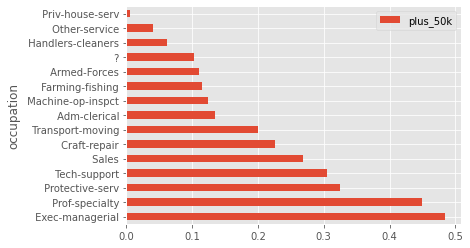

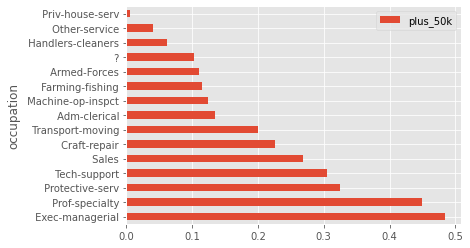

In [40]:
import matplotlib.pyplot as plt

# i like ggplot style
plt.style.use('ggplot')

# get simple plot on the pandas data
myplot = df_pandas.plot(kind='barh', x='occupation', y='plus_50k')

# display the plot (note - display() is a databricks function - 
# more info on plotting in Databricks is here: https://docs.databricks.com/user-guide/visualizations/matplotlib-and-ggplot.html)
display(myplot.figure)

You can also easily get summary stats on a Spark DataFrame like below. [Here](https://databricks.com/blog/2015/06/02/statistical-and-mathematical-functions-with-dataframes-in-spark.html) is a nice blog post that has more examples.<br><br>So this is an example of why you might want to move from Spark SQL into DataFrames API as being able to just call describe() on the Spark DF is easier then trying to do the equivilant in Spark SQL.

In [41]:
# describe df
df_adult.select(df_adult['age'],df_adult['education_num']).describe().show()

+-------+------------------+-----------------+
|summary|               age|    education_num|
+-------+------------------+-----------------+
|  count|             32561|            32561|
|   mean| 38.58164675532078| 10.0806793403151|
| stddev|13.640432553581356|2.572720332067397|
|    min|              17.0|              1.0|
|    max|              90.0|             16.0|
+-------+------------------+-----------------+



### ML Pipeline - Logistic Regression vs Random Forest

Below we will create two [Spark ML Pipelines](https://spark.apache.org/docs/latest/ml-pipeline.html) - one that fits a logistic regression and one that fits a random forest. We will then compare the performance of each.

**Note**: A lot of the code below is adapted from [this example](https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html).

In [44]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

categoricalColumns = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country"]
stages = [] # stages in our Pipeline

for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    # encoder = OneHotEncoderEstimator(inputCol=categoricalCol + "Index", outputCol=categoricalCol + "classVec")
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]

In [46]:
# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="income", outputCol="label")
stages += [label_stringIdx]

In [48]:
# Transform all features into a vector using VectorAssembler
numericCols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [50]:
# Create a Pipeline.
pipeline = Pipeline(stages=stages)
# Run the feature transformations.
#  - fit() computes feature statistics as needed.
#  - transform() actually transforms the features.
pipelineModel = pipeline.fit(df_adult)
dataset = pipelineModel.transform(df_adult)
# Keep relevant columns
selectedcols = ["label", "features"] + cols
dataset = dataset.select(selectedcols)
display(dataset)

DataFrame[label: double, features: vector, age: double, workclass: string, fnlwgt: double, education: string, education_num: double, marital_status: string, occupation: string, relationship: string, race: string, sex: string, capital_gain: double, capital_loss: double, hours_per_week: double, native_country: string, income: string]

In [51]:
### Randomly split data into training and test sets. set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed=100)
print(trainingData.count())
print(testData.count())

22832
9729


In [52]:
from pyspark.sql.functions import avg

# get the rate of the positive outcome from the training data to use as a threshold in the model
training_data_positive_rate = trainingData.select(avg(trainingData['label'])).collect()[0][0] 

print("Positive rate in the training data is {}".format(training_data_positive_rate))

Positive rate in the training data is 0.23988262088297127


#### Logistic Regression - Train

In [53]:
from pyspark.ml.classification import LogisticRegression

# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# set threshold for the probability above which to predict a 1
lr.setThreshold(training_data_positive_rate)
# lr.setThreshold(0.5) # could use this if knew you had balanced data

# Train model with Training Data
lrModel = lr.fit(trainingData)

# get training summary used for eval metrics and other params
lrTrainingSummary = lrModel.summary

# Find the best model threshold if you would like to use that instead of the empirical positve rate
fMeasure = lrTrainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
lrBestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
  
print("Best threshold based on model performance on training data is {}".format(lrBestThreshold))

Best threshold based on model performance on training data is 0.33643403980086295


#### GBM - Train

#### <span style="color:darkblue">Question 3</span>
1. Train a GBTClassifier on the training data, call the trained model 'gbModel'

In [104]:
### Question 3.1 Answer ###
from pyspark.ml.classification import GBTClassifier

# Create initial GBT model
gb = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)
gbModel = gb.fit(trainingData)

In [62]:
gbModel.featureImportances

SparseVector(100, {0: 0.0, 1: 0.0205, 2: 0.0014, 5: 0.0014, 6: 0.0038, 10: 0.0126, 11: 0.0013, 12: 0.0003, 14: 0.0008, 15: 0.0007, 16: 0.0008, 17: 0.002, 23: 0.2699, 29: 0.0169, 31: 0.0634, 33: 0.0034, 34: 0.019, 37: 0.0008, 39: 0.0141, 40: 0.0154, 43: 0.0005, 44: 0.001, 45: 0.001, 47: 0.0095, 48: 0.0015, 49: 0.0005, 52: 0.0134, 54: 0.0002, 55: 0.001, 61: 0.0006, 67: 0.0008, 71: 0.0017, 72: 0.0007, 76: 0.0002, 89: 0.0006, 94: 0.1714, 95: 0.007, 96: 0.1423, 97: 0.0987, 98: 0.029, 99: 0.0699})

#### Logistic Regression - Predict

In [67]:
# make predictions on test data
lrPredictions = lrModel.transform(testData)

# display predictions
display(lrPredictions.select("label", "prediction", "probability").show(5))
#display(lrPredictions)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       1.0|[0.16646708724834...|
|  0.0|       1.0|[0.70012031106346...|
|  0.0|       1.0|[0.53453682932966...|
|  0.0|       1.0|[0.67559303222185...|
|  0.0|       1.0|[0.62237992652147...|
+-----+----------+--------------------+
only showing top 5 rows



None

### GBM - Predict

#### <span style="color:darkblue">Question 4</span>
1. Get predictions on the test data for your GBTClassifier. Call the predictions df 'gbPredictions'.

In [68]:
### Question 4.1 Answer ###

# make predictions on test data
gbPredictions = gbModel.transform(testData)

display(gbPredictions.show(5))

+-----+--------------------+----+---------+--------+---------+-------------+-------------------+---------------+------------+------+-----+------------+------------+--------------+--------------+------+--------------------+--------------------+----------+
|label|            features| age|workclass|  fnlwgt|education|education_num|     marital_status|     occupation|relationship|  race|  sex|capital_gain|capital_loss|hours_per_week|native_country|income|       rawPrediction|         probability|prediction|
+-----+--------------------+----+---------+--------+---------+-------------+-------------------+---------------+------------+------+-----+------------+------------+--------------+--------------+------+--------------------+--------------------+----------+
|  0.0|(100,[0,8,23,29,4...|36.0|  Private|370767.0|  HS-grad|          9.0| Married-civ-spouse| Prof-specialty|     Husband| White| Male|         0.0|      2377.0|          60.0| United-States| <=50K|[-0.5128461723571...|[0.2639200848

None

#### Logistic Regression - Evaluate

#### <span style="color:darkblue">Question 5</span>

1. Complete the print_performance_metrics() function below to also include measures of F1, Precision, Recall, False Positive Rate and True Positive Rate.

In [100]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

def print_performance_metrics(predictions):
  # Evaluate model
  evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
  auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
  aupr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
  print("auc = {}".format(auc))
  print("aupr = {}".format(aupr))

  # get rdd of predictions and labels for mllib eval metrics
  predictionAndLabels = predictions.select("prediction","label").rdd

  # Instantiate metrics objects
  binary_metrics = BinaryClassificationMetrics(predictionAndLabels)
  multi_metrics = MulticlassMetrics(predictionAndLabels)

  # Area under precision-recall curve
  print("Area under PR = {}".format(binary_metrics.areaUnderPR))
  # Area under ROC curve
  print("Area under ROC = {}".format(binary_metrics.areaUnderROC))
  # Accuracy
  print("Accuracy = {}".format(multi_metrics.accuracy))
  # Confusion Matrix
  print(multi_metrics.confusionMatrix())
  
  ### Question 5.1 Answer ###
  
  labels = predictions.select("label").rdd
  # F1
  print("F1 = {}".format(multi_metrics.fMeasure))
  # Precision
  print("Precision = {}".format(multi_metrics.precision))
  # Recall
  print("Recall = {}".format(multi_metrics.recall))
  # FPR
  print("FPR = {}".format(multi_metrics.falsePositiveRate))
  # TPR
  print("TPR = {}".format(multi_metrics.truePositiveRate))
  
  
print_performance_metrics(lrPredictions)

auc = 0.9010633018702178
aupr = 0.7604961593583991
Area under PR = 0.5469752720761771
Area under ROC = 0.818047959721691
Accuracy = 0.8095384931647651
DenseMatrix([[5903., 1462.],
             [ 391., 1973.]])
F1 = <bound method MulticlassMetrics.fMeasure of <pyspark.mllib.evaluation.MulticlassMetrics object at 0x7f0f051c2550>>
Precision = <bound method MulticlassMetrics.precision of <pyspark.mllib.evaluation.MulticlassMetrics object at 0x7f0f051c2550>>
Recall = <bound method MulticlassMetrics.recall of <pyspark.mllib.evaluation.MulticlassMetrics object at 0x7f0f051c2550>>
FPR = <bound method MulticlassMetrics.falsePositiveRate of <pyspark.mllib.evaluation.MulticlassMetrics object at 0x7f0f051c2550>>
TPR = <bound method MulticlassMetrics.truePositiveRate of <pyspark.mllib.evaluation.MulticlassMetrics object at 0x7f0f051c2550>>


#### GBM - Evaluate

In [96]:
print_performance_metrics(gbPredictions)

auc = 0.9035356668194444
aupr = 0.7705854626222547
Area under PR = 0.6403484093263857
Area under ROC = 0.7418879078919709
Accuracy = 0.8464384828862165
DenseMatrix([[6962.,  403.],
             [1091., 1273.]])
F1 = <bound method MulticlassMetrics.fMeasure of <pyspark.mllib.evaluation.MulticlassMetrics object at 0x7f0f05754eb8>>
Precision = <bound method MulticlassMetrics.precision of <pyspark.mllib.evaluation.MulticlassMetrics object at 0x7f0f05754eb8>>
Recall = <bound method MulticlassMetrics.recall of <pyspark.mllib.evaluation.MulticlassMetrics object at 0x7f0f05754eb8>>
FPR = <bound method MulticlassMetrics.falsePositiveRate of <pyspark.mllib.evaluation.MulticlassMetrics object at 0x7f0f05754eb8>>
TPR = <bound method MulticlassMetrics.truePositiveRate of <pyspark.mllib.evaluation.MulticlassMetrics object at 0x7f0f05754eb8>>


## Cross Validation

For each model you can run the below comand to see its params and a brief explanation of each.

In [97]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The

In [59]:
print(gb.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features, current: features)
labelCol: label column name. (default: label, current: label)
lossType: Loss function which GBT tries to minimize (case-insensitive). Supported options: logistic (default: logistic)
maxBins: Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature. (default: 32)
maxDepth: Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. (default: 5)
maxIter: max number of iterations (>= 0). (default: 20, current: 10)
maxMemoryInMB: Maximum memory in MB allocated to histogram aggregation. If too small, then 1 node will be split per iteration, and its aggregates may exceed this size. (default: 256)
minInfoGain: Minimum information gain for a split to be considered at a tree node. (default: 0.0)
minInstancesPerNode: Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1. (default: 1)
predictionCol: prediction column name. (default: prediction)
seed: random seed. (default: 4524766999323601864)
stepSize: Step size (a.k.a. learning rate) in interval (0, 1] for shrinking the contribution of each estimator. (default: 0.1)
subsamplingRate: Fraction of the training data used for learning each decision tree, in range (0, 1]. (default: 1.0)

#### Logisitic Regression - Param Grid

In [105]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
lrParamGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [2, 5])
             .build())

#### GBM - Param Grid

#### <span style="color:darkblue">Question 6</span>

1. Build out a param grid for the gb model, call it 'gbParamGrid'.

In [106]:
### Question 6.1 Answer ###

# Create ParamGrid for Cross Validation
gbParamGrid = (ParamGridBuilder()
             .addGrid(gb.maxDepth, [3,4,5,6,7,8])
             .addGrid(gb.stepSize, [0.1, 0.5, 1.0])
             .addGrid(gb.maxIter, [2, 5])
             .build())

#### Logistic Regression - Perform Cross Validation

In [107]:
# set up an evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# Create CrossValidator
lrCv = CrossValidator(estimator=lr, estimatorParamMaps=lrParamGrid, evaluator=evaluator, numFolds=2)

# Run cross validations
lrCvModel = lrCv.fit(trainingData)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

In [108]:
# below approach to getting at the best params from the best cv model taken from:
# https://stackoverflow.com/a/46353730/1919374

# look at best params from the CV
print(lrCvModel.bestModel._java_obj.getRegParam())
print(lrCvModel.bestModel._java_obj.getElasticNetParam())
print(lrCvModel.bestModel._java_obj.getMaxIter())

0.01
0.5
5


#### GBM - Perform Cross Validation

#### <span style="color:darkblue">Question 7</span>
1. Perform cross validation of params on your 'gb' model.
1. Print out the best params you found.

In [109]:
### Question 7.1 Answer ###

# Create CrossValidator
gbCv = CrossValidator(estimator=gb, estimatorParamMaps=gbParamGrid, evaluator=evaluator, numFolds=2)

# Run cross validations
gbCvModel = gbCv.fit(trainingData)


# set up an evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

In [114]:
### Question 7.2 Answer ###

# look at best params from the CV
print(gbCvModel.bestModel._java_obj.maxDepth)
print(gbCvModel.bestModel._java_obj.stepSize)
print(gbCvModel.bestModel._java_obj.maxIter)


#### Logistic Regression - CV Model Predict

In [123]:
# Use test set to measure the accuracy of our model on new data
lrCvPredictions = lrCvModel.transform(testData)

display(lrCvPredictions)

DataFrame[label: double, features: vector, age: double, workclass: string, fnlwgt: double, education: string, education_num: double, marital_status: string, occupation: string, relationship: string, race: string, sex: string, capital_gain: double, capital_loss: double, hours_per_week: double, native_country: string, income: string, rawPrediction: vector, probability: vector, prediction: double]

#### GBM - CV Model Predict

In [125]:
gbCvPredictions = gbCvModel.transform(testData)

display(gbCvPredictions)

DataFrame[label: double, features: vector, age: double, workclass: string, fnlwgt: double, education: string, education_num: double, marital_status: string, occupation: string, relationship: string, race: string, sex: string, capital_gain: double, capital_loss: double, hours_per_week: double, native_country: string, income: string, rawPrediction: vector, probability: vector, prediction: double]

#### Logistic Regression - CV Model Evaluate

In [126]:
print_performance_metrics(lrCvPredictions)

auc = 0.8973480919380222
aupr = 0.7434534492205122
Area under PR = 0.5263073114774779
Area under ROC = 0.8170953646172562
Accuracy = 0.7930928152944804
DenseMatrix([[5674., 1691.],
             [ 322., 2042.]])
F1 = <bound method MulticlassMetrics.fMeasure of <pyspark.mllib.evaluation.MulticlassMetrics object at 0x7f0f05163978>>
Precision = <bound method MulticlassMetrics.precision of <pyspark.mllib.evaluation.MulticlassMetrics object at 0x7f0f05163978>>
Recall = <bound method MulticlassMetrics.recall of <pyspark.mllib.evaluation.MulticlassMetrics object at 0x7f0f05163978>>
FPR = <bound method MulticlassMetrics.falsePositiveRate of <pyspark.mllib.evaluation.MulticlassMetrics object at 0x7f0f05163978>>
TPR = <bound method MulticlassMetrics.truePositiveRate of <pyspark.mllib.evaluation.MulticlassMetrics object at 0x7f0f05163978>>


#### GBM - CV Model Evaluate

In [79]:
print_performance_metrics(gbCvPredictions)

auc = 0.8989499756467929
aupr = 0.7665167913162426
Area under PR = 0.6435054710769732
Area under ROC = 0.7508083832335329
Accuracy = 0.8484006993726216
DenseMatrix([[ 6919., 429.],
 [ 1045., 1330.]])
F1 = 0.8401553392826959
Precision = 0.8412623026104288
Recall = 0.8484006993726216
FPR = 0.34678393290555576
TPR = 0.8484006993726216

#### Logistic Regression - Model Explore

In [127]:
print('Model Intercept: ', lrCvModel.bestModel.intercept)

Model Intercept:  -6.366757982652404


In [128]:
lrWeights = lrCvModel.bestModel.coefficients
lrWeights = [(float(w),) for w in lrWeights]  # convert numpy type to float, and to tuple
lrWeightsDF = sqlContext.createDataFrame(lrWeights, ["Feature Weight"])
display(lrWeightsDF)

DataFrame[Feature Weight: double]

### Feature Importance

#### <span style="color:darkblue">Question 8</span>
1. Print out a table of feature_name and feature_coefficient from the Logistic Regression model.
<br><br>
Hint: Adapt the code from here: https://stackoverflow.com/questions/42935914/how-to-map-features-from-the-output-of-a-vectorassembler-back-to-the-column-name

In [85]:
### Question 8.1 Answer ###

# from: https://stackoverflow.com/questions/42935914/how-to-map-features-from-the-output-of-a-vectorassembler-back-to-the-column-name

# fill in here

feature_name feature_coefficient
20 educationclassVec_ Doctorate 1.225138e+00
17 educationclassVec_ Prof-school 1.209750e+00
11 educationclassVec_ Masters 8.010314e-01
47 relationshipclassVec_ Wife 7.589803e-01
31 occupationclassVec_ Exec-managerial 6.645506e-01
23 marital_statusclassVec_ Married-civ-spouse 6.435125e-01
43 relationshipclassVec_ Husband 5.382321e-01
10 educationclassVec_ Bachelors 4.405790e-01
5 workclassclassVec_ Self-emp-inc 4.322838e-01
29 occupationclassVec_ Prof-specialty 4.096262e-01
6 workclassclassVec_ Federal-gov 4.075811e-01
86 native_countryclassVec_ Cambodia 3.444299e-01
40 occupationclassVec_ Tech-support 3.171813e-01
80 native_countryclassVec_ France 2.480820e-01
41 occupationclassVec_ Protective-serv 2.035538e-01
52 sexclassVec_ Male 1.749580e-01
33 occupationclassVec_ Sales 9.499070e-02
71 native_countryclassVec_ Japan 8.105796e-02
93 native_countryclassVec_ Scotland 3.767879e-02
96 education_num 2.483800e-02
57 native_countryclassVec_ Germany 8.191203e-03
99 hours_per_week 4.374664e-03
94 age 4.156973e-03
76 native_countryclassVec_ Iran 2.611785e-03
98 capital_loss 4.456794e-04
97 capital_gain 4.797946e-05
95 fnlwgt -7.498115e-07
58 native_countryclassVec_ Canada -8.477189e-03
14 educationclassVec_ Assoc-acdm -4.723760e-02
67 native_countryclassVec_ Italy -5.696215e-02
.. ... ...
75 native_countryclassVec_ Haiti -6.112316e-01
51 raceclassVec_ Amer-Indian-Eskimo -6.145560e-01
91 native_countryclassVec_ Honduras -6.189448e-01
60 native_countryclassVec_ El-Salvador -6.228860e-01
13 educationclassVec_ 11th -6.362003e-01
15 educationclassVec_ 10th -6.577699e-01
34 occupationclassVec_ Other-service -6.732046e-01
38 occupationclassVec_ Handlers-cleaners -6.782282e-01
42 occupationclassVec_ Priv-house-serv -7.377453e-01
39 occupationclassVec_ Farming-fishing -7.430430e-01
45 relationshipclassVec_ Own-child -7.451284e-01
65 native_countryclassVec_ South -7.465534e-01
88 native_countryclassVec_ Thailand -7.724215e-01
24 marital_statusclassVec_ Never-married -7.775786e-01
82 native_countryclassVec_ Ecuador -7.953933e-01
21 educationclassVec_ 5th-6th -7.968925e-01
18 educationclassVec_ 9th -8.060890e-01
22 educationclassVec_ 1st-4th -8.210516e-01
54 native_countryclassVec_ Mexico -8.322623e-01
81 native_countryclassVec_ Greece -8.397554e-01
79 native_countryclassVec_ Peru -8.441932e-01
68 native_countryclassVec_ Dominican-Republic -8.646429e-01
16 educationclassVec_ 7th-8th -9.051719e-01
69 native_countryclassVec_ Vietnam -9.330670e-01
90 native_countryclassVec_ Outlying-US(Guam-USVI-... -9.644833e-01
78 native_countryclassVec_ Nicaragua -9.708063e-01
66 native_countryclassVec_ China -9.719412e-01
92 native_countryclassVec_ Hungary -1.034384e+00
73 native_countryclassVec_ Columbia -1.140475e+00
7 workclassclassVec_ Without-pay -1.159749e+00

[100 rows x 2 columns]

In [86]:
gbCvFeatureImportance = pd.DataFrame([(name, gbCvModel.bestModel.featureImportances[idx]) for idx, name in attrs],columns=['feature_name','feature_importance'])

print(gbCvFeatureImportance.sort_values(by=['feature_importance'],ascending =False))

feature_name feature_importance
23 marital_statusclassVec_ Married-civ-spouse 0.220375
97 capital_gain 0.216766
99 hours_per_week 0.119805
96 education_num 0.101838
98 capital_loss 0.090327
31 occupationclassVec_ Exec-managerial 0.086040
94 age 0.045379
1 workclassclassVec_ Self-emp-not-inc 0.027550
29 occupationclassVec_ Prof-specialty 0.022404
47 relationshipclassVec_ Wife 0.018354
40 occupationclassVec_ Tech-support 0.016017
52 sexclassVec_ Male 0.005164
33 occupationclassVec_ Sales 0.003766
39 occupationclassVec_ Farming-fishing 0.003693
10 educationclassVec_ Bachelors 0.003019
14 educationclassVec_ Assoc-acdm 0.002312
37 occupationclassVec_ Transport-moving 0.002270
5 workclassclassVec_ Self-emp-inc 0.001967
21 educationclassVec_ 5th-6th 0.001824
43 relationshipclassVec_ Husband 0.001445
49 raceclassVec_ Black 0.001373
38 occupationclassVec_ Handlers-cleaners 0.001325
61 native_countryclassVec_ India 0.001160
12 educationclassVec_ Assoc-voc 0.001126
95 fnlwgt 0.001024
16 educationclassVec_ 7th-8th 0.000994
26 marital_statusclassVec_ Separated 0.000901
11 educationclassVec_ Masters 0.000759
59 native_countryclassVec_ Puerto-Rico 0.000519
57 native_countryclassVec_ Germany 0.000285
.. ... ...
36 occupationclassVec_ ? 0.000000
30 occupationclassVec_ Craft-repair 0.000000
28 marital_statusclassVec_ Married-spouse-absent 0.000000
27 marital_statusclassVec_ Widowed 0.000000
25 marital_statusclassVec_ Divorced 0.000000
41 occupationclassVec_ Protective-serv 0.000000
42 occupationclassVec_ Priv-house-serv 0.000000
24 marital_statusclassVec_ Never-married 0.000000
44 relationshipclassVec_ Not-in-family 0.000000
45 relationshipclassVec_ Own-child 0.000000
46 relationshipclassVec_ Unmarried 0.000000
22 educationclassVec_ 1st-4th 0.000000
48 raceclassVec_ White 0.000000
19 educationclassVec_ 12th 0.000000
65 native_countryclassVec_ South 0.000000
51 raceclassVec_ Amer-Indian-Eskimo 0.000000
18 educationclassVec_ 9th 0.000000
53 native_countryclassVec_ United-States 0.000000
17 educationclassVec_ Prof-school 0.000000
55 native_countryclassVec_ ? 0.000000
56 native_countryclassVec_ Philippines 0.000000
15 educationclassVec_ 10th 0.000000
58 native_countryclassVec_ Canada 0.000000
13 educationclassVec_ 11th 0.000000
60 native_countryclassVec_ El-Salvador 0.000000
9 educationclassVec_ Some-college 0.000000
62 native_countryclassVec_ Cuba 0.000000
63 native_countryclassVec_ England 0.000000
64 native_countryclassVec_ Jamaica 0.000000
50 raceclassVec_ Asian-Pac-Islander 0.000000

[100 rows x 2 columns]

#### <span style="color:darkblue">Question 9</span>
1. Build and train a RandomForestClassifier and print out a table of feature importances from it.

In [88]:
### Question 9.1 Answer ###

from pyspark.ml.classification import # fill in here

rf = # fill in here

rfModel = # fill in here

rfFeatureImportance = # fill in here

print(# fill in here)

feature_name feature_importance
43 relationshipclassVec_ Husband 0.162466
23 marital_statusclassVec_ Married-civ-spouse 0.130222
94 age 0.117549
24 marital_statusclassVec_ Never-married 0.091650
97 capital_gain 0.082070
96 education_num 0.069659
99 hours_per_week 0.067999
44 relationshipclassVec_ Not-in-family 0.034909
31 occupationclassVec_ Exec-managerial 0.022731
17 educationclassVec_ Prof-school 0.022483
52 sexclassVec_ Male 0.021403
98 capital_loss 0.019937
10 educationclassVec_ Bachelors 0.017821
29 occupationclassVec_ Prof-specialty 0.015052
11 educationclassVec_ Masters 0.013807
45 relationshipclassVec_ Own-child 0.013467
46 relationshipclassVec_ Unmarried 0.012889
47 relationshipclassVec_ Wife 0.009872
48 raceclassVec_ White 0.008749
25 marital_statusclassVec_ Divorced 0.008365
34 occupationclassVec_ Other-service 0.008066
20 educationclassVec_ Doctorate 0.007454
8 educationclassVec_ HS-grad 0.007267
5 workclassclassVec_ Self-emp-inc 0.005913
16 educationclassVec_ 7th-8th 0.002630
54 native_countryclassVec_ Mexico 0.002104
32 occupationclassVec_ Adm-clerical 0.002041
38 occupationclassVec_ Handlers-cleaners 0.001876
0 workclassclassVec_ Private 0.001874
27 marital_statusclassVec_ Widowed 0.001791
.. ... ...
28 marital_statusclassVec_ Married-spouse-absent 0.000006
56 native_countryclassVec_ Philippines 0.000003
70 native_countryclassVec_ Guatemala 0.000002
92 native_countryclassVec_ Hungary 0.000000
87 native_countryclassVec_ Laos 0.000000
89 native_countryclassVec_ Yugoslavia 0.000000
90 native_countryclassVec_ Outlying-US(Guam-USVI-... 0.000000
59 native_countryclassVec_ Puerto-Rico 0.000000
22 educationclassVec_ 1st-4th 0.000000
93 native_countryclassVec_ Scotland 0.000000
85 native_countryclassVec_ Trinadad&Tobago 0.000000
58 native_countryclassVec_ Canada 0.000000
14 educationclassVec_ Assoc-acdm 0.000000
7 workclassclassVec_ Without-pay 0.000000
86 native_countryclassVec_ Cambodia 0.000000
42 occupationclassVec_ Priv-house-serv 0.000000
60 native_countryclassVec_ El-Salvador 0.000000
68 native_countryclassVec_ Dominican-Republic 0.000000
82 native_countryclassVec_ Ecuador 0.000000
62 native_countryclassVec_ Cuba 0.000000
80 native_countryclassVec_ France 0.000000
79 native_countryclassVec_ Peru 0.000000
78 native_countryclassVec_ Nicaragua 0.000000
77 native_countryclassVec_ Portugal 0.000000
18 educationclassVec_ 9th 0.000000
40 occupationclassVec_ Tech-support 0.000000
73 native_countryclassVec_ Columbia 0.000000
72 native_countryclassVec_ Poland 0.000000
71 native_countryclassVec_ Japan 0.000000
83 native_countryclassVec_ Ireland 0.000000

[100 rows x 2 columns]